In [2]:
import os
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
from tensorboardX import SummaryWriter
import globalvar as gl

# 参数配置

In [27]:
#os.makedirs("images", exist_ok=True)


batch_size=64
lr=0.0002#adam: learning rate
b1=0.5#adam: decay of first order momentum of gradient
b2=0.999#adam: decay of first order momentum of gradient
n_cpu=8#number of cpu threads to use during batch generation
h_dim=128
latent_dim=3#dimensionality of the latent code
img_size=28#size of each image dimension
channels=1#number of image channels
sample_interval=400#interval between image sampling
img_shape = (channels, img_size, img_size)
cuda = True if torch.cuda.is_available() else False
log_dir=os.path.join(os.path.abspath('.'),'log{}d'.format(latent_dim))


gl._init()
gl.set_value('log_dir',log_dir)
gl.set_value('batch_size',batch_size)
gl.set_value('lr',lr)
gl.set_value('b1',b1)
gl.set_value('b2',b2)
gl.set_value('n_cpu',n_cpu)
gl.set_value('h_dim',h_dim)
gl.set_value('latent_dim',latent_dim)
gl.set_value('img_size',img_size)
gl.set_value('channels',channels)
gl.set_value('sample_interval',sample_interval)
gl.set_value('img_shape',img_shape)
gl.set_value('cuda',cuda)

# AAE(标签不用于discriminator)

In [28]:
import imp
import base
imp.reload(base)
model=base.AAE()

In [16]:
s_epoch=100
e_epoch=150

In [13]:
model.train(s_epoch=s_epoch,e_epoch=e_epoch)
model.save(log_dir,e_epoch=e_epoch)

In [14]:
model.load(log_dir,e_epoch=e_epoch)
model.generate_hidden(log_dir)

data has been saved successfully


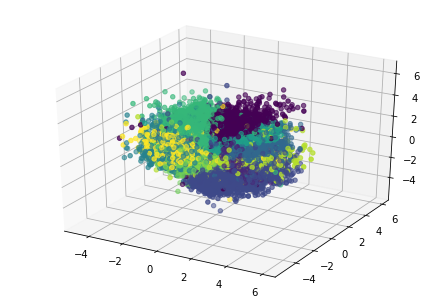

In [37]:
model.load(log_dir,e_epoch=e_epoch)
model.plot()

accuracy is 0.8773


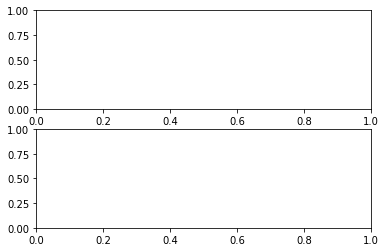

0.8773

In [29]:
e_epoch=100
model.load(log_dir,e_epoch=e_epoch)
model.pred(3,weights='uniform',plot=True)

## 随机生成图片

In [7]:
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits"""
    # Sample noise
    z = Variable(Tensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    gen_imgs = decoder(z)
    save_image(gen_imgs.data, "images/{}.png" .format(batches_done) , nrow=n_row, normalize=True)

for i in range(0,8):
    sample_image(n_row=10, batches_done='A{}'.format(i))

# AAE(标签用于discriminator)

In [7]:
# ----------
#  Training
# ----------
import pdb

cls_num=10
global_step=0
for epoch in range(n_epochs):
    for i, (imgs, y) in enumerate(dataloader):
        y_hot=Tensor(torch.zeros(len(y),cls_num+1).numpy())
        y_hot[range(0,len(y)),y]=1
        y_hot[:,cls_num]=1

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss =  adversarial_loss(discriminator(encoded_imgs), valid) + pixelwise_loss(
            decoded_imgs, real_imgs
        )
        writer.add_scalars('scalars_mean0.3_var0.1_v2',{'g_loss':g_loss},global_step=global_step)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z=np.zeros((imgs.shape[0], latent_dim))
        for idx in range(0,imgs.shape[0]):
            z[idx,:]=np.random.normal(y[idx]*0.3,0.1,(1,latent_dim))
        z=Tensor(z)

        # Measure discriminator's ability to classify real from generated samples
#         real_loss = adversarial_loss(discriminator(torch.cat((z,y_hot),dim=1)), valid)
#         fake_loss = adversarial_loss(discriminator(torch.cat((encoded_imgs.detach(),y_hot),dim=1)), fake)
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)
        writer.add_scalars('scalars_mean0.3_var0.1_v2', {'real_loss': real_loss,'fake_loss':fake_loss,'d_loss':d_loss},global_step=global_step)
        d_loss.backward()
        optimizer_D.step()
        global_step=global_step+1
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)
    if epoch % 5 == 0:
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

[Epoch 0/50] [Batch 937/938] [D loss: 0.702088] [G loss: 0.899756]
[Epoch 5/50] [Batch 937/938] [D loss: 0.693114] [G loss: 0.886722]
[Epoch 10/50] [Batch 937/938] [D loss: 0.693396] [G loss: 0.852638]
[Epoch 15/50] [Batch 937/938] [D loss: 0.692065] [G loss: 0.850500]
[Epoch 20/50] [Batch 937/938] [D loss: 0.692202] [G loss: 0.841444]
[Epoch 25/50] [Batch 937/938] [D loss: 0.693751] [G loss: 0.830778]
[Epoch 30/50] [Batch 937/938] [D loss: 0.693081] [G loss: 0.856001]
[Epoch 35/50] [Batch 937/938] [D loss: 0.693721] [G loss: 0.852651]
[Epoch 40/50] [Batch 937/938] [D loss: 0.692702] [G loss: 0.846815]
[Epoch 45/50] [Batch 937/938] [D loss: 0.693418] [G loss: 0.843173]


In [8]:
torch.save(encoder.state_dict(),'./encoder_new_epoch_50_v2.pkl')
torch.save(decoder.state_dict(),'./decoder_new_epoch_50_v2.pkl')
torch.save(discriminator.state_dict(),'./discriminator_new_epoch_50_v2.pkl')

In [ ]:
encoder.load_state_dict(torch.load('./encoder_new_epoch_50_v2.pkl'))
decoder.load_state_dict(torch.load('./decoder_new_epoch_50_v2.pkl'))
discriminator.load_state_dict(torch.load('./discriminator_new_epoch_50_v2.pkl'))

In [9]:
import pandas as pd
hcode=np.zeros((60000,4))
idx=0
for i, (imgs, y) in enumerate(dataloader):
    real_imgs = Variable(imgs.type(Tensor))
    encoded_imgs = encoder(real_imgs)
    hcode[idx:idx+imgs.shape[0],0:3]=encoded_imgs.cpu().detach().numpy()
    hcode[idx:idx+imgs.shape[0],3]=y
    idx+=imgs.shape[0]
df=pd.DataFrame(hcode)
df.to_csv('./logs3d/hcode_new_AAE_v2.csv',index=False)

# 修改discriminator

In [4]:
cls_num=10
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity

class Merge_y(nn.Module):
    def __init__(self):
        super(Merge_y, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(cls_num+1, latent_dim)
        )

    def forward(self, y_hot,z):
        validity = self.model(y_hot)
        return validity+z

discriminator = Discriminator()
merge_y=Merge_y()

if cuda:
    discriminator.cuda()
    merge_y.cuda()

In [5]:
# ----------
#  Training
# ----------
import pdb
global_step=0
for epoch in range(n_epochs):
    for i, (imgs, y) in enumerate(dataloader):
        y_hot=Tensor(torch.zeros(len(y),cls_num+1).numpy())
        y_hot[range(0,len(y)),y]=1
        y_hot[:,cls_num]=1

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss =  adversarial_loss(discriminator(merge_y(y_hot,encoded_imgs)), valid) + pixelwise_loss(decoded_imgs, real_imgs)
        writer.add_scalars('scalars_mean0.3_var0.1_v3',{'g_loss':g_loss},global_step=global_step)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z=np.zeros((imgs.shape[0], latent_dim))
        for idx in range(0,imgs.shape[0]):
            z[idx,:]=np.random.normal(y[idx]*0.3,0.1,(1,latent_dim))
        z=Tensor(z)

        # Measure discriminator's ability to classify real from generated samples
#         real_loss = adversarial_loss(discriminator(torch.cat((z,y_hot),dim=1)), valid)
#         fake_loss = adversarial_loss(discriminator(torch.cat((encoded_imgs.detach(),y_hot),dim=1)), fake)
        real_loss = adversarial_loss(discriminator(merge_y(y_hot,z)), valid)
        fake_loss = adversarial_loss(discriminator(merge_y(y_hot,encoded_imgs.detach())), fake)
        d_loss = 0.5 * (real_loss + fake_loss)
        writer.add_scalars('scalars_mean0.3_var0.1_v3', {'real_loss': real_loss,'fake_loss':fake_loss,'d_loss':d_loss},global_step=global_step)
        d_loss.backward()
        optimizer_D.step()
        global_step=global_step+1
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)
    if epoch % 5 == 0:
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

[Epoch 0/50] [Batch 937/938] [D loss: 1.753529] [G loss: 0.303204]
[Epoch 5/50] [Batch 937/938] [D loss: 4.093544] [G loss: 0.192533]
[Epoch 10/50] [Batch 937/938] [D loss: 4.862344] [G loss: 0.164223]
[Epoch 15/50] [Batch 937/938] [D loss: 5.955349] [G loss: 0.179261]
[Epoch 20/50] [Batch 937/938] [D loss: 6.131660] [G loss: 0.185920]
[Epoch 25/50] [Batch 937/938] [D loss: 7.207675] [G loss: 0.161002]
[Epoch 30/50] [Batch 937/938] [D loss: 7.404850] [G loss: 0.152891]
[Epoch 35/50] [Batch 937/938] [D loss: 7.367630] [G loss: 0.157359]
[Epoch 40/50] [Batch 937/938] [D loss: 7.860887] [G loss: 0.180303]
[Epoch 45/50] [Batch 937/938] [D loss: 7.592329] [G loss: 0.151546]


In [6]:
torch.save(encoder.state_dict(),'./encoder_new_epoch_50_v3.pkl')
torch.save(decoder.state_dict(),'./decoder_new_epoch_50_v3.pkl')
torch.save(discriminator.state_dict(),'./discriminator_new_epoch_50_v3.pkl')
torch.save(merge_y.state_dict(),'./merge_y_epoch_50_v3.pkl')

In [7]:
import pandas as pd
hcode=np.zeros((60000,4))
idx=0
for i, (imgs, y) in enumerate(dataloader):
    real_imgs = Variable(imgs.type(Tensor))
    encoded_imgs = encoder(real_imgs)
    hcode[idx:idx+imgs.shape[0],0:3]=encoded_imgs.cpu().detach().numpy()
    hcode[idx:idx+imgs.shape[0],3]=y
    idx+=imgs.shape[0]
df=pd.DataFrame(hcode)
df.to_csv('./logs3d/hcode_new_AAE_v3.csv',index=False)